In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from cvx.covariance.ewma import iterated_ewma
from backtest import ProblemData, run_backtest
from metrics import Metrics
from utils import from_cov_to_corr, get_volas

sns.set_theme(font_scale=1.5, style="whitegrid")
colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:6]

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load data

In [4]:
returns_BTC = pd.read_csv('../data/BTC_returns.csv', index_col=0, parse_dates=True).squeeze(); returns_BTC.name = 'BTC'
returns_ETH = pd.read_csv('../data/ETH_returns.csv', index_col=0, parse_dates=True).squeeze(); returns_ETH.name = 'ETH'
returns_industry = pd.read_csv('../data/industry_returns.csv', index_col=0, parse_dates=True) / 100

returns = pd.concat([returns_BTC, returns_ETH, returns_industry], axis=1).loc['2017-01-01':]
returns = returns.drop(columns=['Other'])

n_assets = returns.shape[1]
times = pd.read_csv('times.csv', index_col=1, parse_dates=True).index

In [75]:
values = (1+returns.loc[times]).cumprod()

metrics = pd.DataFrame(index=returns.columns, columns=['Return', 'Volatility', 'Sharpe', 'Drawdown'], dtype=float).T
drawdown = 1 - values.div(values.cummax())

metrics.loc['Return'] = returns.loc[times].mean() * 250
metrics.loc['Volatility'] = returns.loc[times].std() * np.sqrt(250)
metrics.loc['Sharpe'] = returns.loc[times].mean() / returns.std() * np.sqrt(250)
metrics.loc['Drawdown'] = drawdown.max()
# move BTC and ETC to last columns
metrics = metrics[['Cnsmr',	'Manuf', 'HiTec', 'Hlth ', 'BTC', 'ETH']]
metrics.round(3)

,Cnsmr,Manuf,HiTec,Hlth,BTC,ETH
Return,0.141,0.114,0.207,0.108,0.435,0.471
Volatility,0.193,0.205,0.239,0.180,0.581,0.716
Sharpe,0.762,0.577,0.899,0.617,0.731,0.599
Drawdown,0.285,0.427,0.354,0.268,0.833,0.939


# Covariance matrices

In [5]:
iewma_pair = (63, 125)

iterator = iterated_ewma(returns, vola_halflife=iewma_pair[0], cov_halflife=iewma_pair[1], min_periods_vola=21, min_periods_cov=63)
covariances = {iterate.time: iterate.covariance for iterate in iterator}
covariances_no_crypto = {time: cov.copy().iloc[2:, 2:] for time, cov in covariances.items()}
covariances_only_crypto = {time: cov.copy().iloc[:2, :2] for time, cov in covariances.items()}
    
choleskies = {time: pd.DataFrame(np.linalg.cholesky(cov), index=cov.index, columns=cov.columns) for time, cov in covariances.items()}
choleskies_no_crypto = {time: pd.DataFrame(np.linalg.cholesky(cov), index=cov.index, columns=cov.columns) for time, cov in covariances_no_crypto.items()}
choleskies_only_crypto = {time: pd.DataFrame(np.linalg.cholesky(cov), index=cov.index, columns=cov.columns) for time, cov in covariances_only_crypto.items()}

# Look at correlations

In [6]:
correlations = from_cov_to_corr(covariances)
volas = get_volas(covariances)

<Axes: >

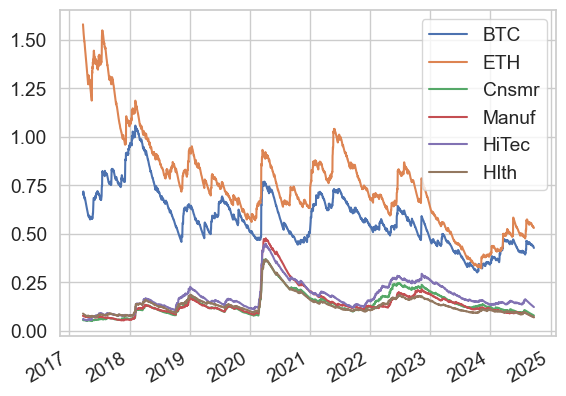

In [7]:
sns.set_theme(font_scale=1.25, style="whitegrid")
(volas).plot(color=colors);
# plt.savefig('/Users/kasper/Documents/Stanford/Research/My papers/crypto/crypto_paper/figures/asset_volas.png')

In [8]:
max_corrs = pd.Series({t: np.triu(corr.iloc[:2], k=1)[:, 2:].max() for t, corr in correlations.items()})
min_corrs = pd.Series({t: np.triu(corr.iloc[:2], k=1)[:, 2:].min() for t, corr in correlations.items()})
avg_corrs = pd.Series({t: np.triu(corr.iloc[:2], k=1)[:, 2:].mean() for t, corr in correlations.items()})

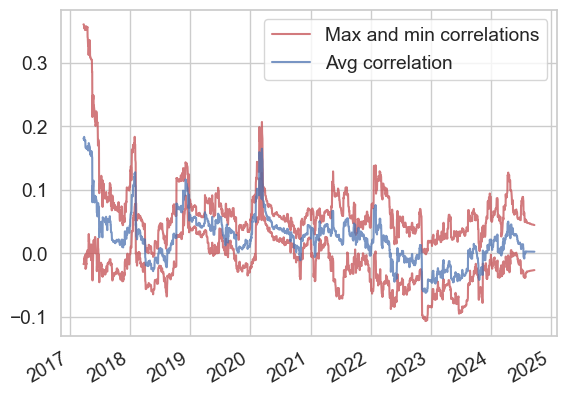

In [9]:
max_corrs.plot(label='Max and min correlations', color='r', alpha=0.75)
min_corrs.plot(color='r', alpha=0.75)
avg_corrs.plot(label='Avg correlation', color='b', alpha=0.75)
plt.legend();

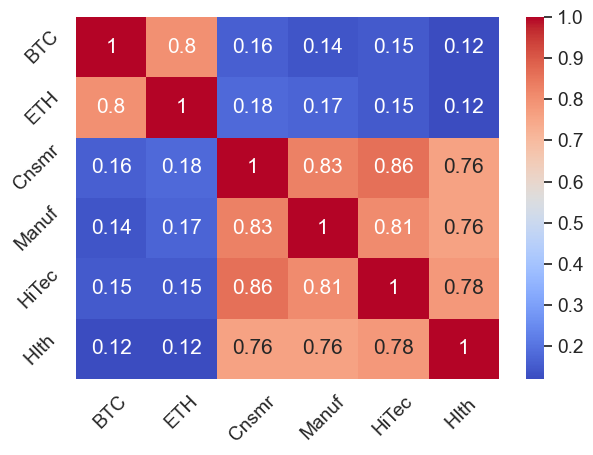

In [10]:
date = '2020-03-01'
covariance = covariances[pd.Timestamp(date)]
volas = np.sqrt(np.diag(covariance))
correlation = covariance / np.outer(volas, volas)

sns.heatmap(correlation.round(2), annot=True, cmap='coolwarm')
plt.xticks(rotation=45)
plt.yticks(rotation=45);
plt.tight_layout()
# plt.savefig('/Users/kasper/Documents/Stanford/Research/My papers/crypto/crypto_paper/figures/correlations_2020-03-01.png')

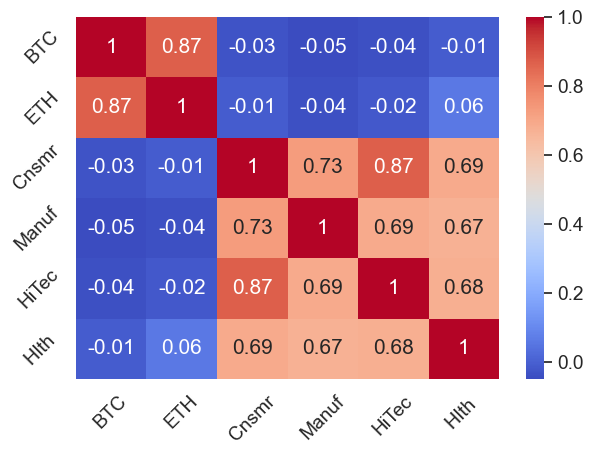

In [11]:
date = '2023-05-01'
covariance = covariances[pd.Timestamp(date)]
volas = np.sqrt(np.diag(covariance))
correlation = covariance / np.outer(volas, volas)

sns.heatmap(correlation.round(2), annot=True, cmap='coolwarm')
plt.xticks(rotation=45)
plt.yticks(rotation=45);
plt.tight_layout()
# plt.savefig('/Users/kasper/Documents/Stanford/Research/My papers/crypto/crypto_paper/figures/correlations_2023-05-01.png')

# Problem data

In [12]:
gamma = None
w_min = None
w_max = 0.1
n_crypto = 2

problem_data_no_crypto = ProblemData(
    n_assets=returns.iloc[:, n_crypto:].shape[1],
    n_crypto=0,
    gamma=gamma,
    w_min=w_min,
    w_max=w_max,
    risk_limit=0.1,
    leverage_limit=None,
    asset_names=returns.columns[n_crypto:],
    method='risk_parity',
    risk_allocations=np.full(returns.iloc[:, n_crypto:].shape[1], 1 / returns.iloc[:, n_crypto:].shape[1]),
    dilute=True,
)

problem_data_only_crypto = ProblemData(
    n_assets=returns.iloc[:, :n_crypto].shape[1],
    n_crypto=n_crypto,
    gamma=gamma,
    w_min=w_min,
    w_max=w_max,
    risk_limit=0.1,
    leverage_limit=None,
    asset_names=returns.columns[:n_crypto],
    method='risk_parity',
    risk_allocations=np.full(returns.iloc[:, :n_crypto].shape[1], 1 / returns.iloc[:, :n_crypto].shape[1]),
    dilute=True,
)

problem_data = ProblemData(
    n_assets=returns.shape[1],
    n_crypto=n_crypto,
    gamma=gamma,
    w_min=w_min,
    w_max=w_max,
    risk_limit=0.1,
    leverage_limit=None,
    asset_names=returns.columns,
    method='risk_parity',
    risk_allocations=np.full(returns.shape[1], 1 / returns.shape[1]),
    dilute=True,
)

# Backtest

In [13]:
backtest_no_crypto = run_backtest(choleskies_no_crypto, problem_data_no_crypto, returns.iloc[:, n_crypto:])
backtest_only_crypto = run_backtest(choleskies_only_crypto, problem_data_only_crypto, returns.iloc[:, :n_crypto])
backtest = run_backtest(choleskies, problem_data, returns)

### No crypto

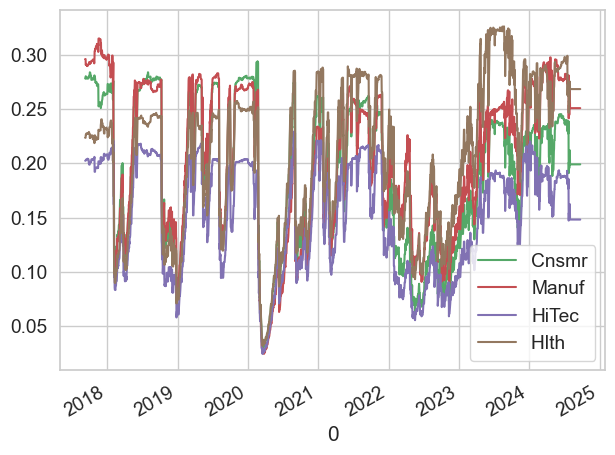

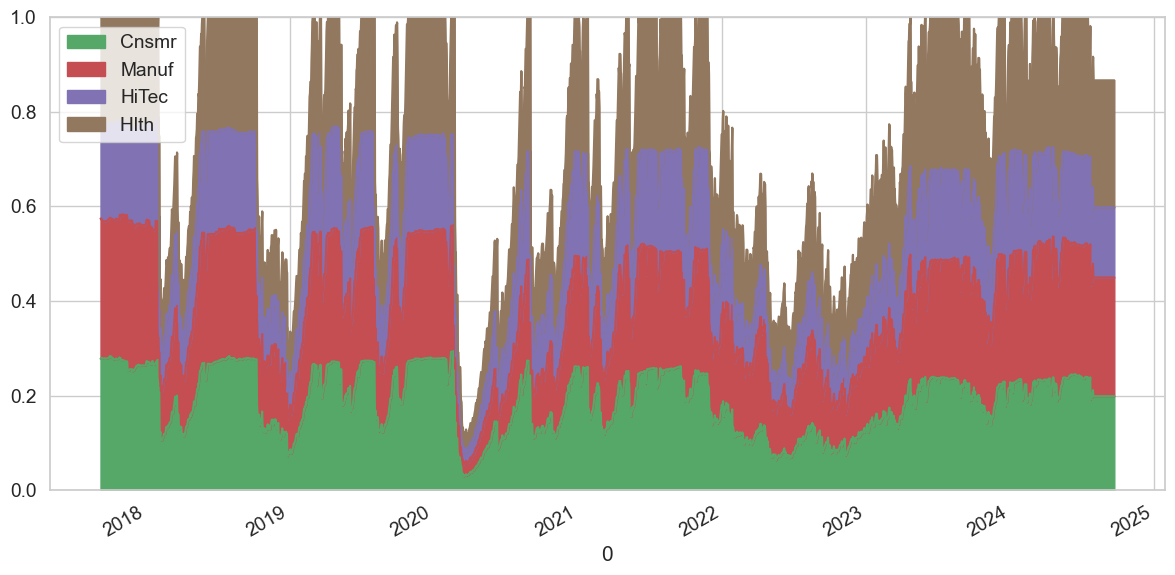

Cash allocation: 0.2455642858767666


In [14]:
backtest_no_crypto.weights.loc[times].plot(color=colors[2:]);
plt.gcf().autofmt_xdate()
plt.tight_layout()

weights = backtest_no_crypto.weights.loc[times].copy()
fig, ax = plt.subplots(figsize=(12, 6))
weights.plot(kind='area', stacked=True, ax=ax, color=colors[2:])
ax.legend(loc='upper left')
plt.gcf().autofmt_xdate()
plt.ylim(0, 1)
plt.tight_layout()
# plt.savefig('/Users/kasper/Documents/Stanford/Research/My papers/crypto/crypto_paper/figures/portfolio_weights_industry.png')
plt.show()
print(f'Cash allocation: {1 - weights.sum(axis=1).mean()}')

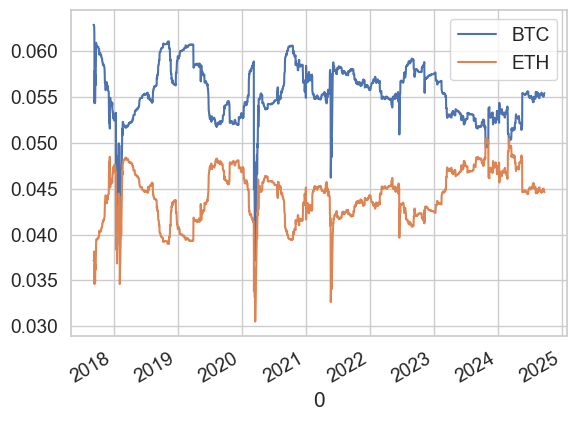

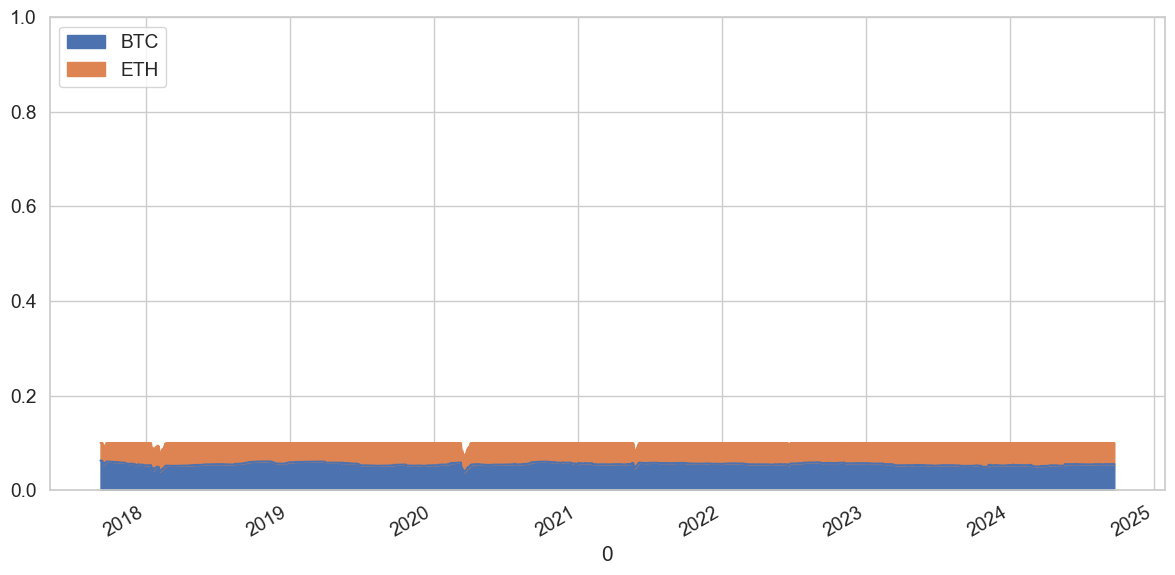

Cash allocation: 0.9004630423128305


In [15]:
backtest_only_crypto.weights.loc[times].plot();

weights = backtest_only_crypto.weights.loc[times].copy()
fig, ax = plt.subplots(figsize=(12, 6))
weights.plot(kind='area', stacked=True, ax=ax, color=colors[:2])
ax.legend(loc='upper left')
plt.gcf().autofmt_xdate()
plt.ylim(0, 1)
plt.tight_layout()
# plt.savefig('/Users/kasper/Documents/Stanford/Research/My papers/crypto/crypto_paper/figures/portfolio_weights_crypto.png')
plt.show()
print(f'Cash allocation: {1 - weights.sum(axis=1).mean()}')

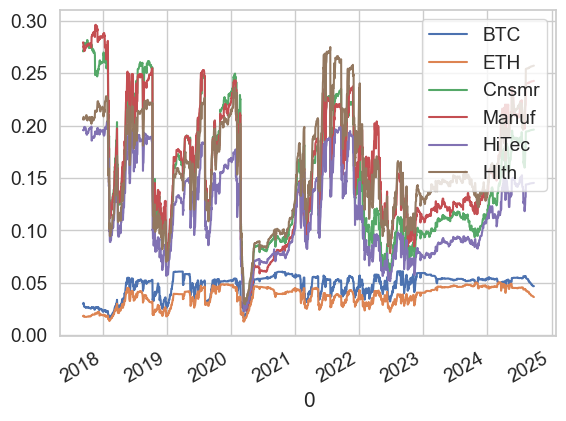

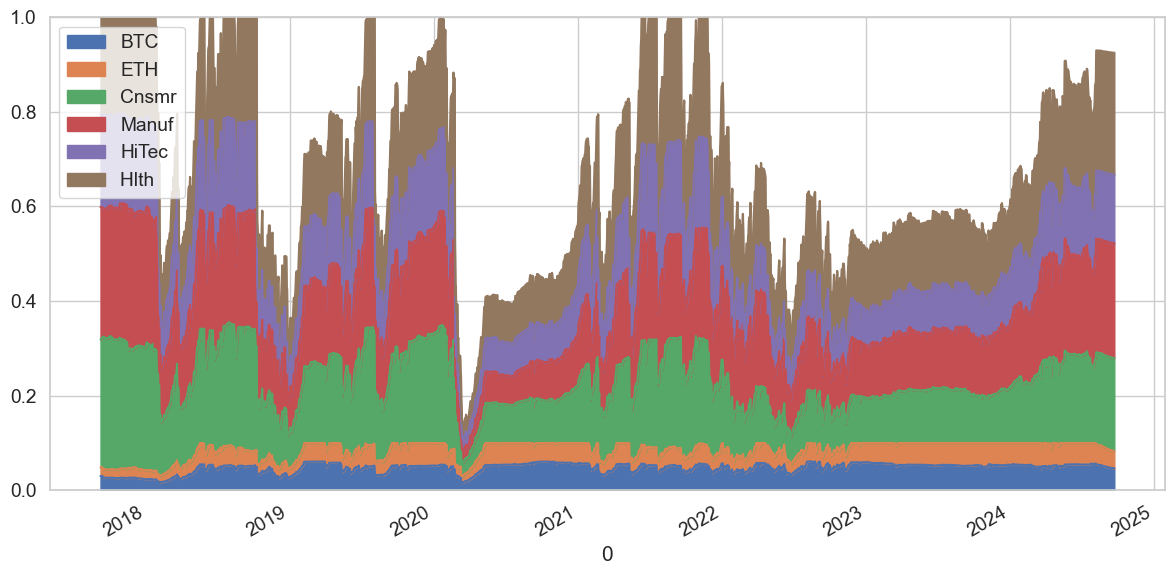

<Figure size 1200x600 with 0 Axes>

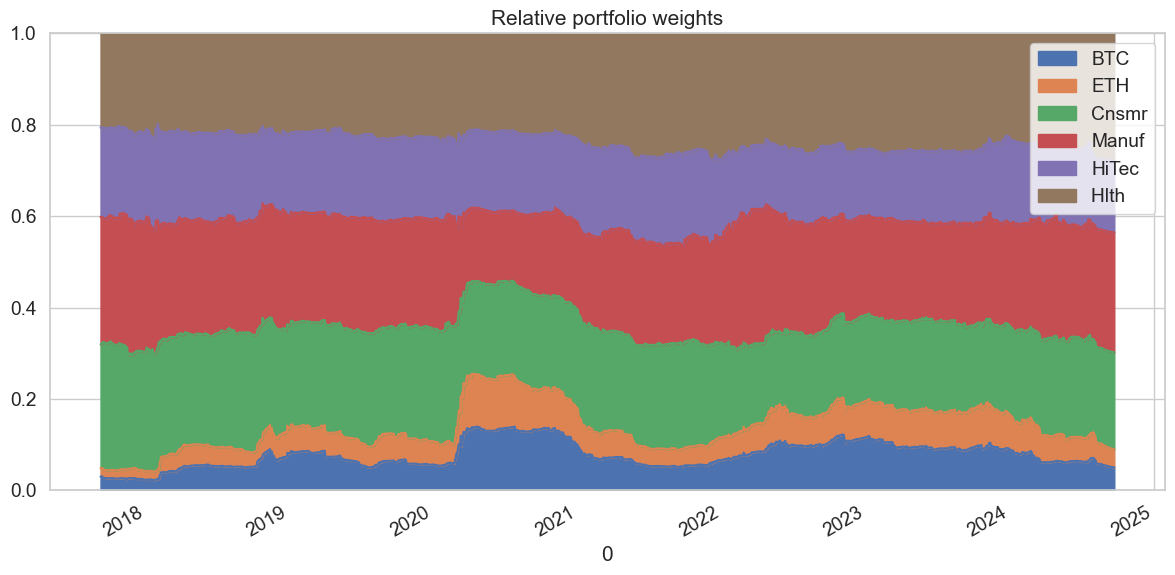

Cash allocation: 0.3288184671234523


In [16]:
backtest.weights.loc[times].plot();

weights = backtest.weights.loc[times].copy()
fig, ax = plt.subplots(figsize=(12, 6))
weights.plot(kind='area', stacked=True, ax=ax, color=colors)
ax.legend(loc='upper left')
plt.gcf().autofmt_xdate()
plt.ylim(0, 1)
plt.tight_layout()
# plt.savefig('/Users/kasper/Documents/Stanford/Research/My papers/crypto/crypto_paper/figures/portfolio_weights.png')
plt.show()

plt.figure(figsize=(12, 6))
fig, ax = plt.subplots(figsize=(12, 6))
(weights / weights.sum(axis=1).values[:, None]).plot(kind='area', stacked=True, ax=ax, color=colors)
plt.title('Relative portfolio weights')
plt.gcf().autofmt_xdate()
plt.ylim(0, 1)
plt.tight_layout()
# plt.savefig('/Users/kasper/Documents/Stanford/Research/My papers/crypto/crypto_paper/figures/portfolio_weights_relative.png')
plt.show();
print(f'Cash allocation: {1 - weights.sum(axis=1).mean()}')

In [17]:
metrics_no_crypto = Metrics(backtest_no_crypto.weights.loc[times], backtest_no_crypto.cash.loc[times], returns.loc[times].iloc[:, n_crypto:].shift(-1))
metrics_only_crypto = Metrics(backtest_only_crypto.weights.loc[times], backtest_only_crypto.cash.loc[times], returns.loc[times].iloc[:, :n_crypto].shift(-1))
metrics = Metrics(backtest.weights.loc[times], backtest.cash.loc[times], returns.shift(-1))

# pandas dataframe of metrics.summary   
summary_df = pd.concat([metrics_no_crypto.summary, metrics_only_crypto.summary, metrics.summary], axis=1)
summary_df.columns = ['No Crypto', 'Only Crypto', 'All']
summary_df.round(3)

,No Crypto,Only Crypto,All
Mean return,0.060,0.045,0.082
Volatility,0.082,0.059,0.082
Sharpe ratio,0.727,0.750,0.999
Max drawdown,0.125,0.162,0.196


In [18]:
# metrics.portfolio_returns.to_csv('CRA.csv') # NOTE: keep this

### Correlation of portfolios over time

In [19]:
portfolio_returns = pd.concat([metrics_no_crypto.portfolio_returns, metrics_only_crypto.portfolio_returns, metrics.portfolio_returns], axis=1)
iterator = iterated_ewma(portfolio_returns, vola_halflife=63, cov_halflife=125, min_periods_vola=21, min_periods_cov=63)
covariances = {iterate.time: iterate.covariance for iterate in iterator}

correlations = from_cov_to_corr(covariances)
corr_0_1 = pd.Series({t: corr.iloc[0, 1] for t, corr in correlations.items()})

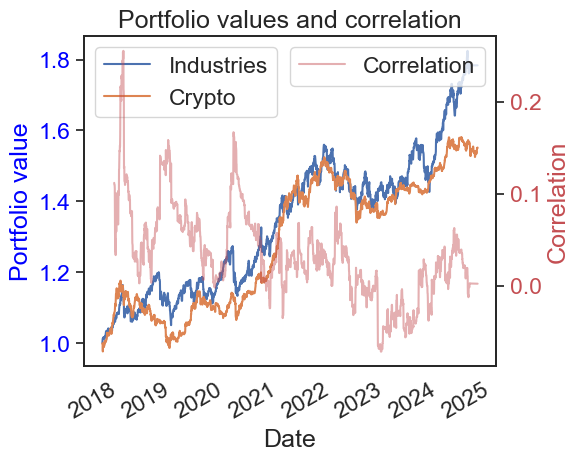

In [21]:
sns.set_theme(font_scale=1.5, style="white")

cumprod_data = (1 + portfolio_returns).iloc[:, :2].cumprod()
corr_data = corr_0_1

fig, ax1 = plt.subplots()

# Plot the cumulative product on the left y-axis
ax1.plot(cumprod_data.index, cumprod_data, label=['Industries', 'Crypto'])
ax1.set_xlabel('Date')
ax1.set_ylabel('Portfolio value', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.legend(loc='upper left')

# Create a second y-axis for the correlation plot
ax2 = ax1.twinx()
ax2.plot(corr_data.index, corr_data, color='r', label='Correlation', alpha=0.45)
ax2.set_ylabel('Correlation', color='r')
ax2.tick_params(axis='y', labelcolor='r')
ax2.legend(loc='upper right')

# Set the plot title and layout
plt.title('Portfolio values and correlation')
fig.tight_layout()
fig.autofmt_xdate()
plt.show()


### Portfolio values over time

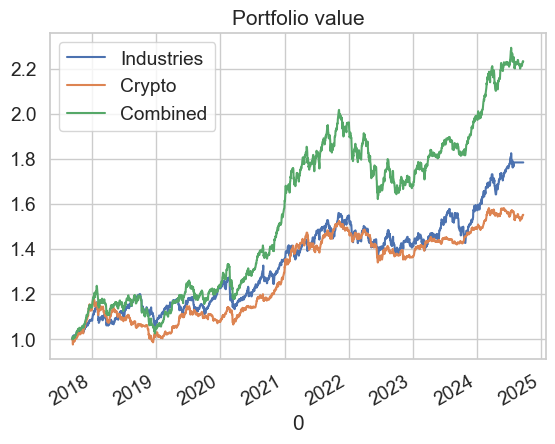

In [23]:
sns.set(font_scale=1.25, style="whitegrid")
metrics_no_crypto.portfolio_value.loc[times].plot(label=f'No Crypto (SR={metrics_no_crypto.sharpe:.2f})')
metrics_only_crypto.portfolio_value.loc[times].plot(label=f'Only Crypto (SR={metrics_only_crypto.sharpe:.2f})')
metrics.portfolio_value.loc[times].plot(label=f'Combined (SR={metrics.sharpe:.2f})')
plt.title('Portfolio value')
plt.legend(['Industries', 'Crypto', 'Combined']);
# plt.savefig('/Users/kasper/Documents/Stanford/Research/My papers/crypto/crypto_paper/figures/portfolio_value.png');

# Annualized metrics

In [24]:
from collections import namedtuple

MetricTuple = namedtuple('MetricTuple', ['mean', 'stdev', 'sharpe'])
def get_metrics(returns, freq):
    mean = returns.resample(freq).mean() * 250
    stdev = returns.resample(freq).std() * np.sqrt(250)
    sharpe = mean / stdev

    return MetricTuple(mean, stdev, sharpe)


In [25]:
freq = 'YE'
m_tuple_no_crypt = get_metrics(metrics_no_crypto.portfolio_returns, freq)
m_tuple_only_crypto = get_metrics(metrics_only_crypto.portfolio_returns, freq)
m_tuple = get_metrics(metrics.portfolio_returns, freq)

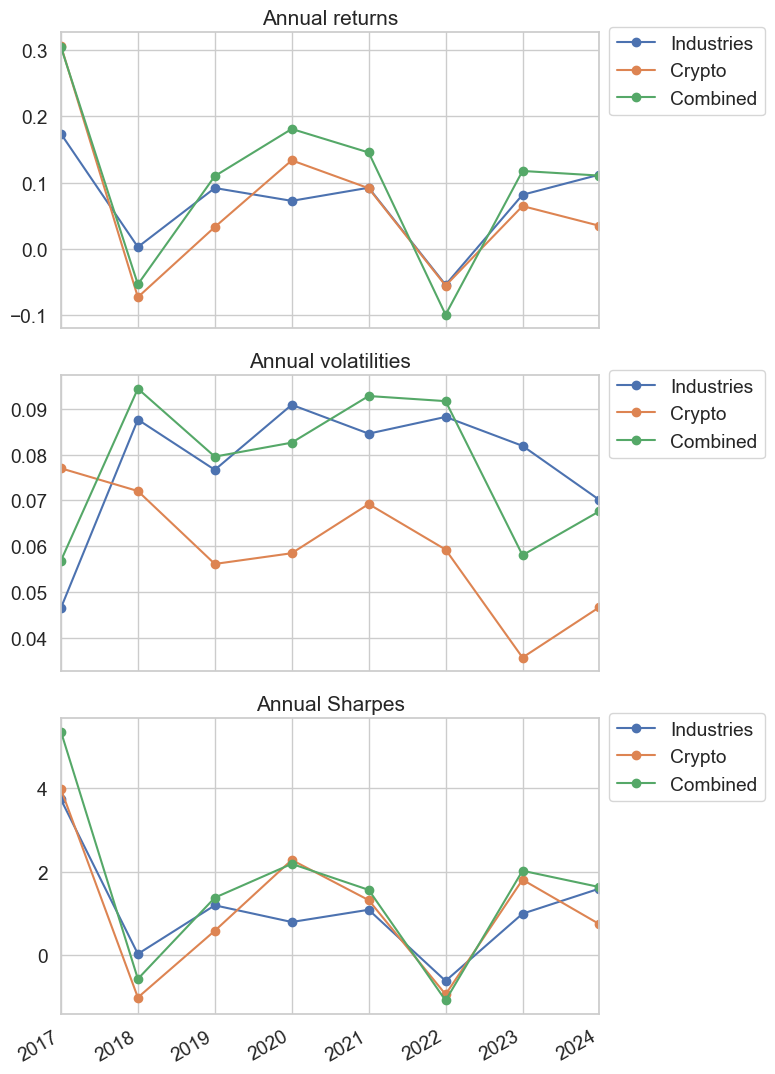

In [26]:
# same as above but all in one figure side to side

fig, axs = plt.subplots(3, 1, figsize=(8, 11))
plt.sca(axs[0])
plt.title('Annual returns')
m_tuple_no_crypt.mean.plot(marker='o', label=f'No crypto (mean {m_tuple_no_crypt.mean.mean():.2f}, std {m_tuple_no_crypt.mean.std():.2f})')
m_tuple_only_crypto.mean.plot(marker='o', label=f'Only crypto (mean {m_tuple_only_crypto.mean.mean():.2f}, std {m_tuple_only_crypto.mean.std():.2f})')
m_tuple.mean.plot(marker='o', label=f'Combined (mean {m_tuple.mean.mean():.2f}, std {m_tuple.mean.std():.2f})')
plt.gcf().autofmt_xdate()
plt.legend(['Industries', 'Crypto', 'Combined'], bbox_to_anchor=(1.,1.05), loc='upper left');

plt.sca(axs[1])
plt.title('Annual volatilities')
m_tuple_no_crypt.stdev.plot(marker='o', label=f'No crypto (mean {m_tuple_no_crypt.stdev.mean():.2f}, std {m_tuple_no_crypt.stdev.std():.2f})')
m_tuple_only_crypto.stdev.plot(marker='o', label=f'Only crypto (mean {m_tuple_only_crypto.stdev.mean():.2f}, std {m_tuple_only_crypto.stdev.std():.2f})')
m_tuple.stdev.plot(marker='o', label=f'Combined (mean {m_tuple.stdev.mean():.2f}, std {m_tuple.stdev.std():.2f})')
plt.gcf().autofmt_xdate()
plt.legend(['Industries', 'Crypto', 'Combined'], bbox_to_anchor=(1.,1.05), loc='upper left');

plt.sca(axs[2])
plt.title('Annual Sharpes')
m_tuple_no_crypt.sharpe.plot(marker='o', label=f'No crypto (mean {m_tuple_no_crypt.sharpe.mean():.2f}, std {m_tuple_no_crypt.sharpe.std():.2f})')
m_tuple_only_crypto.sharpe.plot(marker='o', label=f'Only crypto (mean {m_tuple_only_crypto.sharpe.mean():.2f}, std {m_tuple_only_crypto.sharpe.std():.2f})')
m_tuple.sharpe.plot(marker='o', label=f'Combined (mean {m_tuple.sharpe.mean():.2f}, std {m_tuple.sharpe.std():.2f})')
plt.gcf().autofmt_xdate()
plt.legend(['Industries', 'Crypto', 'Combined'], bbox_to_anchor=(1.,1.05), loc='upper left');

plt.tight_layout();
# plt.savefig('/Users/kasper/Documents/Stanford/Research/My papers/crypto/crypto_paper/figures/annual_metrics.png')


# Shapley attributions

In [1]:
from itertools import permutations
from shapley import get_lifts
import numpy as np
from tqdm import tqdm
import multiprocessing as mp
import pandas as pd

%load_ext autoreload
%autoreload 2

ints = np.arange(5)
all_permutations = list(permutations(ints))

In [2]:
lifts = []
pool = mp.Pool(mp.cpu_count())
for l in tqdm(pool.imap(get_lifts, [list(p) for p in all_permutations]), total=len(all_permutations)):
    lifts.append(l)
pool.close()
pool.join()

100%|██████████| 120/120 [09:22<00:00,  4.69s/it]


In [7]:
lifts_sharpe = pd.concat([l.sharpe for l in lifts], axis=1).T
lifts_vola = pd.concat([l.vola for l in lifts], axis=1).T
lifts_mean = pd.concat([l.mean_return for l in lifts], axis=1).T
lifts_drawdown = pd.concat([l.drawdown for l in lifts], axis=1).T

shapley = pd.DataFrame(dtype=float)
shapley['Mean'] = lifts_mean.mean()
shapley['Vola'] = lifts_vola.mean()
shapley['Sharpe'] = lifts_sharpe.mean()
shapley['Drawdown'] = lifts_drawdown.mean()

shapley = shapley.T
shapley['Total'] = shapley.sum(axis=1)  
shapley = shapley[['Cnsmr', 'Manuf', 'HiTec', 'Hlth ', 'Crypto', 'Total']]
shapley

,Cnsmr,Manuf,HiTec,Hlth,Crypto,Total
Mean,0.018005,0.006471,0.024476,0.007956,0.024743,0.081651
Vola,0.018234,0.018042,0.019834,0.018492,0.007113,0.081716
Sharpe,0.200709,0.061698,0.263970,0.076456,0.396374,0.999207
Drawdown,0.033217,0.023656,0.032094,0.034596,0.072592,0.196155
